# Fine-Tuning OpenAI Language Models with Noisily Labeled Data

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cleanlab/examples/blob/master/fine_tune_LLM/LLM_with_noisy_labels_cleanlab.ipynb)

This notebook demonstrates how data-centric AI tools like cleanlab can improve a fine-tuned Large Language Model (LLM; a.k.a. Foundation Model). Such tools optimize the dataset itself rather than altering the model architecture/hyperparameters — running the exact same fine-tuning code on the improved dataset boosts test-set performance by 37% on a politeness classification task studied here. We achieve similar accuracy gains via the same data-centric AI process across 3 state-of-the-art LLM models one can fine-tune via the OpenAI API: Davinci, Ada, and Curie. These are variants of the base LLM underpinning GPT-3 & ChatGPT.

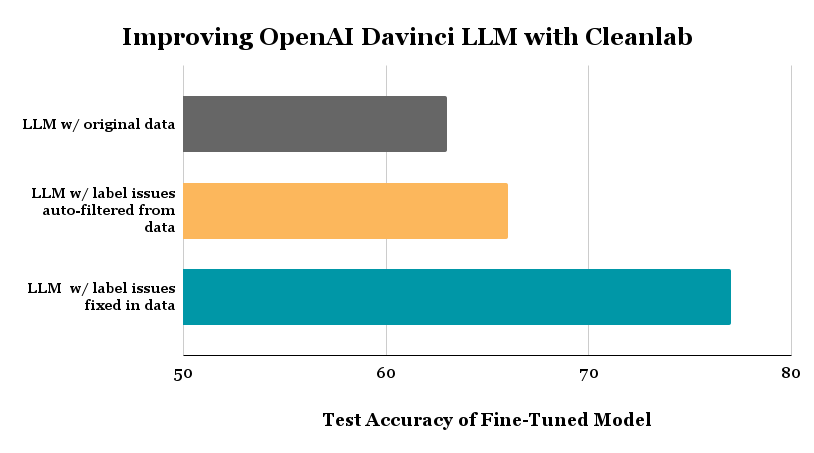

Labeled data powers AI/ML in the enterprise, but real-world datasets have been found to contain between 7-50% annotation errors. Imperfectly-labeled text data hampers the training (and evaluation of) ML models across tasks like intent recognition, entity recognition, and sequence generation. Although pretrained LLMs are equipped with a lot of world knowledge, their performance is adversely affected by noisy training data (as noted by OpenAI).  Here we illustrate data-centric techniques to mitigate the effect of label noise without changing any code related to model architecture, hyperparameters, or training. These data quality improvement techniques should thus remain applicable even for future advanced LLMs like GPT-10. 

## Setup and Import Data



In [ ]:
!pip install openai
!pip install cleanlab

import openai
import pandas as pd
pd.set_option('max_colwidth', None)
import numpy as np
import os
from cleanlab.filter import find_label_issues
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from openai.embeddings_utils import get_embedding

# Import train and test data.
train = pd.read_csv("https://s.cleanlab.ai/stanford-politeness/fine-tuning/train.csv")
test = pd.read_csv("https://s.cleanlab.ai/stanford-politeness/fine-tuning/test.csv")

# Cost Warning
This notebook will require the use of OpenAI credits or billing. The estimated costs are as follows:

Davinci
- Embeddings: ~\\$10-13
- Fine Tuning: ~\\$3-6

Curie
- Embeddings: ~\\$2-4
- Fine Tuning: ~\\$2-4

Ada
- Embeddings: <\\$1
- Fine Tuning: <\\$1

In [ ]:
# You need to set your OpenAI API keys here
%env OPENAI_API_KEY = {key}
openai.api_key = '{key}'

# Our Data
Here we consider a 3-class variant of the Stanford Politeness Dataset, which has text phrases labeled as: impolite, neutral, or polite. Annotated by human raters, some of these labels are naturally low-quality. 

Our training dataset has 1916 examples each labeled by a single human annotator, and thus some may be unreliable.

The test dataset has 480 examples each labeled by 5 annotators, and we use their consensus label as a high-quality approximation of the true politeness (measuring test accuracy against these consensus labels). To ensure a fair comparison, this test dataset remains fixed throughout our experiments (all label cleaning / dataset modification is only done in the training set). We reformat these CSV files into the jsonl file type required by OpenAI’s fine-tuning API.

In [ ]:
train.head()

,prompt,completion
0,Question: how do we move the content from the existing page to the new page? How do we reference the space to the new page?,neutral
1,Why would you doubt that. And for that matter why wouldn't you rewrite it yourself?,impolite
2,Thank you for closing out this debate. Can you please restore the history for GFDL purposes?,neutral
3,"You may want to take a look at <url>. Can you be specific on what ""spamming"" is in this context?",neutral
4,"The consequences apparently have no sliding scale? It's either ""you're blocked,"" or you're not?",impolite


In [ ]:
test.head()

,prompt,completion
0,Excuse me? What are you accusing me of doing?,impolite
1,I don't understand Tasc0??,impolite
2,"Well, you leaved me also curious. Why was it not appropriate?",impolite
3,"Hi, I meant to do this a long time ago, but I guess I forgot. You are the ""Sandpiper"" on the HP wiki right?",neutral
4,DONE. Do you think everything is now sorted so I can beep Brain Boulton?,neutral


## Prepare Data

In [ ]:
# Helper method to format data according to OpenAI requirements.
# Saves the resulting formatted jsonl file to fname.
def format_data(df, fname):
  # Save to jsonl file with name fname.
  df.to_json(fname, orient='records', lines=True)
  # printf \"y\nn\ny\n\" lets us pipe input arguments into format_data command
  # the \"y\nn\ny\n\" is inputing:
  # - y (yes) to add whitespace before completion
  # - n (no) to split into train/test
  # - y (yes) to save as jsonl file
  sys_cmd = f"printf \"y\nn\ny\n\" | openai tools fine_tunes.prepare_data -f {fname}"
  # Execute command.
  os.system(sys_cmd)
  return

In [ ]:
# Format test and train data.
format_data(train, 'train.jsonl')
format_data(test, 'test.jsonl')

# Overview

This notebook walks through the following steps:

- Use the original data to fine-tune different state-of-the-art LLMs via the OpenAI API: Davinci, Ada, and Curie.
- Establish the baseline accuracy of each fine-tuned model on a test set with high-quality labels (established via consensus and high-agreement amongst many human annotators who rated each test example).
- Use the `find_label_issues()` method from the cleanlab package to automatically identify hundreds of mislabeled examples.
- Remove the data with automatically-flagged label issues from the dataset, and then fine-tune the exact same LLMs on the auto-filtered dataset. **This simple step reduces the error in Davinci model predictions by 8%!**
- Use a **no-code** solution to efficiently fix the label errors in the dataset, and then fine-tune the exact same LLM on the fixed dataset. **This reduces the error in Davinci model predictions by 37%!**

Similar gains are achieved via these same processes for the Ada and Curie models — in all cases, nothing was changed about the model nor the fine-tuning code! 

## Fine-Tune and Evaluate OpenAI Model

Here’s how our Python code looks to fine-tune the Davinci LLM for 3-class classification and evaluate its test accuracy. 

In [ ]:
# Starts a fine-tuning job using the davinci model.
!openai api fine_tunes.create -t "train_prepared.jsonl" -v "test_prepared.jsonl" --compute_classification_metrics --classification_n_classes 3 -m davinci --suffix "baseline"

Found potentially duplicated files with name 'train_prepared.jsonl', purpose 'fine-tune' and size 336697 bytes
file-vqt0WzPQIrfrfUIMGLIVPJw3
file-g29hvLzawW2NRoAgMJVLf0Jc
file-gMn6EF6jG0YZQbOC5Osoe98s
Enter file ID to reuse an already uploaded file, or an empty string to upload this file anyway: 
Upload progress: 100% 337k/337k [00:00<00:00, 388Mit/s]
Uploaded file from train_prepared.jsonl: file-BWyYtPvUOj3bEciNpn9PnXH4
Found potentially duplicated files with name 'test_prepared.jsonl', purpose 'fine-tune' and size 86248 bytes
file-kQ9nvpgBZ4ymSwZTSHrcathS
file-A8UDyjjGn77nDSTnQVpKNwZR
file-Gn7Xe3h8RzjpBG2bkNt1ZpdU
file-ij3XWzohVe7DHe1MfGeOmlIK
file-JPRgknZ0XXyJpHVTslOVH5GP
file-XMpLsORHGXPHIsPpuEGhCLjT
Enter file ID to reuse an already uploaded file, or an empty string to upload this file anyway: 
Upload progress: 100% 86.2k/86.2k [00:00<00:00, 125Mit/s]
Uploaded file from test_prepared.jsonl: file-47roCLnANxzRtxbfZjc0Wta3
Created fine-tune: ft-9800F2gcVNzyMdTLKcMqAtJ5
Streaming even

Once the job completes, we query a fine_tunes.results endpoint to see the test accuracy achieved when fine-tuning this LLM on the original training dataset.

In [ ]:
# Query API for results and save them to CSV that we can view.
# You will need to change the fine-tune ID from the above cell.
!openai api fine_tunes.results -i ft-9800F2gcVNzyMdTLKcMqAtJ5 > baseline-davinci.csv
base_df = pd.read_csv('baseline-davinci.csv')
baseline_acc = base_df.iloc[-1]['classification/accuracy']
print(f"Fine-tuning Accuracy: {baseline_acc:.1%}")

Fine-tuning Accuracy: 63.1%


Our baseline Davinci LLM achieves a test accuracy of 63% when fine-tuned on the raw training data with possibly noisy labels. Even a state-of-the-art LLM like the Davinci model produces lackluster results for this classification task, is it because the data labels are noisy? 

# Automatically Find Label Issues

The [cleanlab](https://github.com/cleanlab/cleanlab) Python package employs Confident Learning algorithms to estimate which data are mislabeled in a classification dataset. These algorithms require **out-of-sample** predicted class probabilities for all of our training examples and apply a novel form of calibration to determine when to trust the model over the given label in the data.   

To obtain these predicted probabilities we:

1. Use the OpenAI API to compute embeddings from the Davinci model for all of our training examples. You can download the embeddings [here](https://cleanlab-public.s3.amazonaws.com/Datasets/stanford-politeness/LLM-blog/train_embed_davinci.npy).
2. Fit a logistic regression model on the embeddings and labels in the original data. We use 10-fold cross-validation which allows us to produce out-of-sample predicted class probabilities for every example in the training dataset.

## Get Embeddings

In [ ]:
# This model is expensive ($15) so we will load in the embeddings from AWS instead of re-computing them.
embedding_model = "text-similarity-davinci-001"

# You can also use this model which is very cheap (few cents) with slightly less quality.
# embedding_model = "text-embedding-ada-002"

# Get embeddings using the OpenAI embedding API.
embedding_df = train.copy()
embedding_df["embedding"] = embedding_df.prompt.apply(lambda x: get_embedding(x, engine=embedding_model))

In [ ]:
# Load in embeddings computed with Davinci model.
!wget -nc https://cleanlab-public.s3.amazonaws.com/Datasets/stanford-politeness/LLM-blog/train_embed_davinci.npy

## Find Label Issues

With just one line of code, cleanlab estimates which examples have label issues in our training dataset.

In [ ]:
embeddings = np.load('train_embed_davinci.npy')
model = LogisticRegression()

label_to_num={'impolite':0, 'neutral':1, 'polite':2}
labels = train.completion
labels_num = [label_to_num[l] for l in labels]

# Generate out-of-sample predicted probabilities for all of the training data with 10-fold cross validation.
pred_probs = cross_val_predict(estimator=model, X=embeddings, y=labels, cv=10, method="predict_proba")

# Returns list of indices of label issues, sorted by self_confidence.
issue_idx = find_label_issues(labels_num, pred_probs, return_indices_ranked_by='self_confidence')

# Show some examples!
train.iloc[issue_idx].head()

,prompt,completion
633,"I don't understand how you find it appropriate to talk about your illegal drug use on your user page. Also, how do you have the right to ban other people's usernames with a name like ""'''BONG'''warrior""?",polite
592,You see how time consuming and annoying it is when a person keeps on telling you to provide a source. Why do you want ''Michael'' to be just another compilation album?,polite
1089,"<url> is one of the three fundamental Wikipedia content policies; why is it a ""shame"" you have to follow it? What did you mean by ""people like you""?",polite
838,I'll take a look at getLogEntries when I have time. Would you mind adding me as a committer?,impolite
1272,One last thought on groups claiming to be the FI - don't the <url>s claim to be the Fourth International? Or perhaps it's just *a* Fourth International?,polite


Let’s take a look at a few of the label issues automatically identified in our dataset. Here’s one example that is clearly mislabeled:

- Phrase: *I'll take a look at getLogEntries when I have time. Would you mind adding me as a committer?*
- Label: *impolite*

Labeling errors like this are why we might be seeing poor model results.

**Note: `find_label_issues`is able to determine which of the original `labels` are potentially incorrect given only out-of-sample `pred_probs` from a trained model.**

## Filter label issues and fine-tune a more robust LLM

Now that we have the indices of potentially mislabeled examples (identified via automated techniques), let’s remove these 471 examples from our training dataset. Fine-tuning the exact same Davinci LLM on the filtered dataset achieves a test accuracy of 66% (on the same test data where our original Davinci LLM achieved 63% accuracy). We reduced the error-rate of the model by 8% using less but better quality training data!

In [ ]:
# Remove the label errors found by cleanlab.
train_dropped = train.drop(issue_idx).reset_index(drop=True)
format_data(train_dropped, 'train_dropped.jsonl')

In [ ]:
# Train a more robust classifier with less erroneous data.
!openai api fine_tunes.create -t "train_dropped_prepared.jsonl" -v "test_prepared.jsonl" --compute_classification_metrics --classification_n_classes 3 -m davinci --suffix "dropped"

Found potentially duplicated files with name 'train_dropped_prepared.jsonl', purpose 'fine-tune' and size 252414 bytes
file-ITAYOMWmqKTGDm4agNcNl837
file-LjY86Rtqf3Xyxa1C99RecG18
file-X8gdrPtDD5JR0TcVayhPFHFW
file-nipvjQRxN36018PcMYQ5R0vZ
Enter file ID to reuse an already uploaded file, or an empty string to upload this file anyway: 
Upload progress: 100% 252k/252k [00:00<00:00, 230Mit/s]
Uploaded file from train_dropped_prepared.jsonl: file-3eaJp9rH3HpLYPZTIoGdJxJz
Found potentially duplicated files with name 'test_prepared.jsonl', purpose 'fine-tune' and size 86248 bytes
file-A8UDyjjGn77nDSTnQVpKNwZR
file-kQ9nvpgBZ4ymSwZTSHrcathS
file-Gn7Xe3h8RzjpBG2bkNt1ZpdU
file-ij3XWzohVe7DHe1MfGeOmlIK
file-JPRgknZ0XXyJpHVTslOVH5GP
file-XMpLsORHGXPHIsPpuEGhCLjT
file-47roCLnANxzRtxbfZjc0Wta3
file-tGOmIEgWSMDsp1JFMoz7dRSX
file-MDeMFZCtCSYpzSI7UhgGXDM7
file-4ZLDinbfZ2A8ej5x0KsZL0li
file-0RePynbyMb1Z6TeRPt3ZneR3
file-qwi0VypvDVTG1Py3jspBQ3Fr
Enter file ID to reuse an already uploaded file, or an empty

In [ ]:
# Query API for results and save them to CSV that we can view.
# You will need to change the fine-tune ID from the above cell.
!openai api fine_tunes.results -i ft-InhTRQGu11gIDlVJUt0LYbEx > dropped-davinci.csv
dropped_df = pd.read_csv('dropped-davinci.csv')
dropped_acc = dropped_df.iloc[-1]['classification/accuracy']
print(f"Fine-tuning Accuracy: {dropped_acc:.1%}")

Fine-tuning Accuracy: 66.0%


## Fixing the Label Errors

Instead of just dropping the potential label issues, the smarter (yet more complex) way to improve our dataset would be to correct the label issues by hand. This simultaneously removes a noisy data point and adds an accurate one, but making such corrections manually is cumbersome.

[Cleanlab Studio](https://cleanlab.ai/studio/) provides a user-friendly interface to make these changes **without writing a single line of code.** Simply upload your dataset and Studio computes everything we just did above via provided AI and data-quality algorithms, so you can spend more time *fixing* the issues instead of just *finding* them.

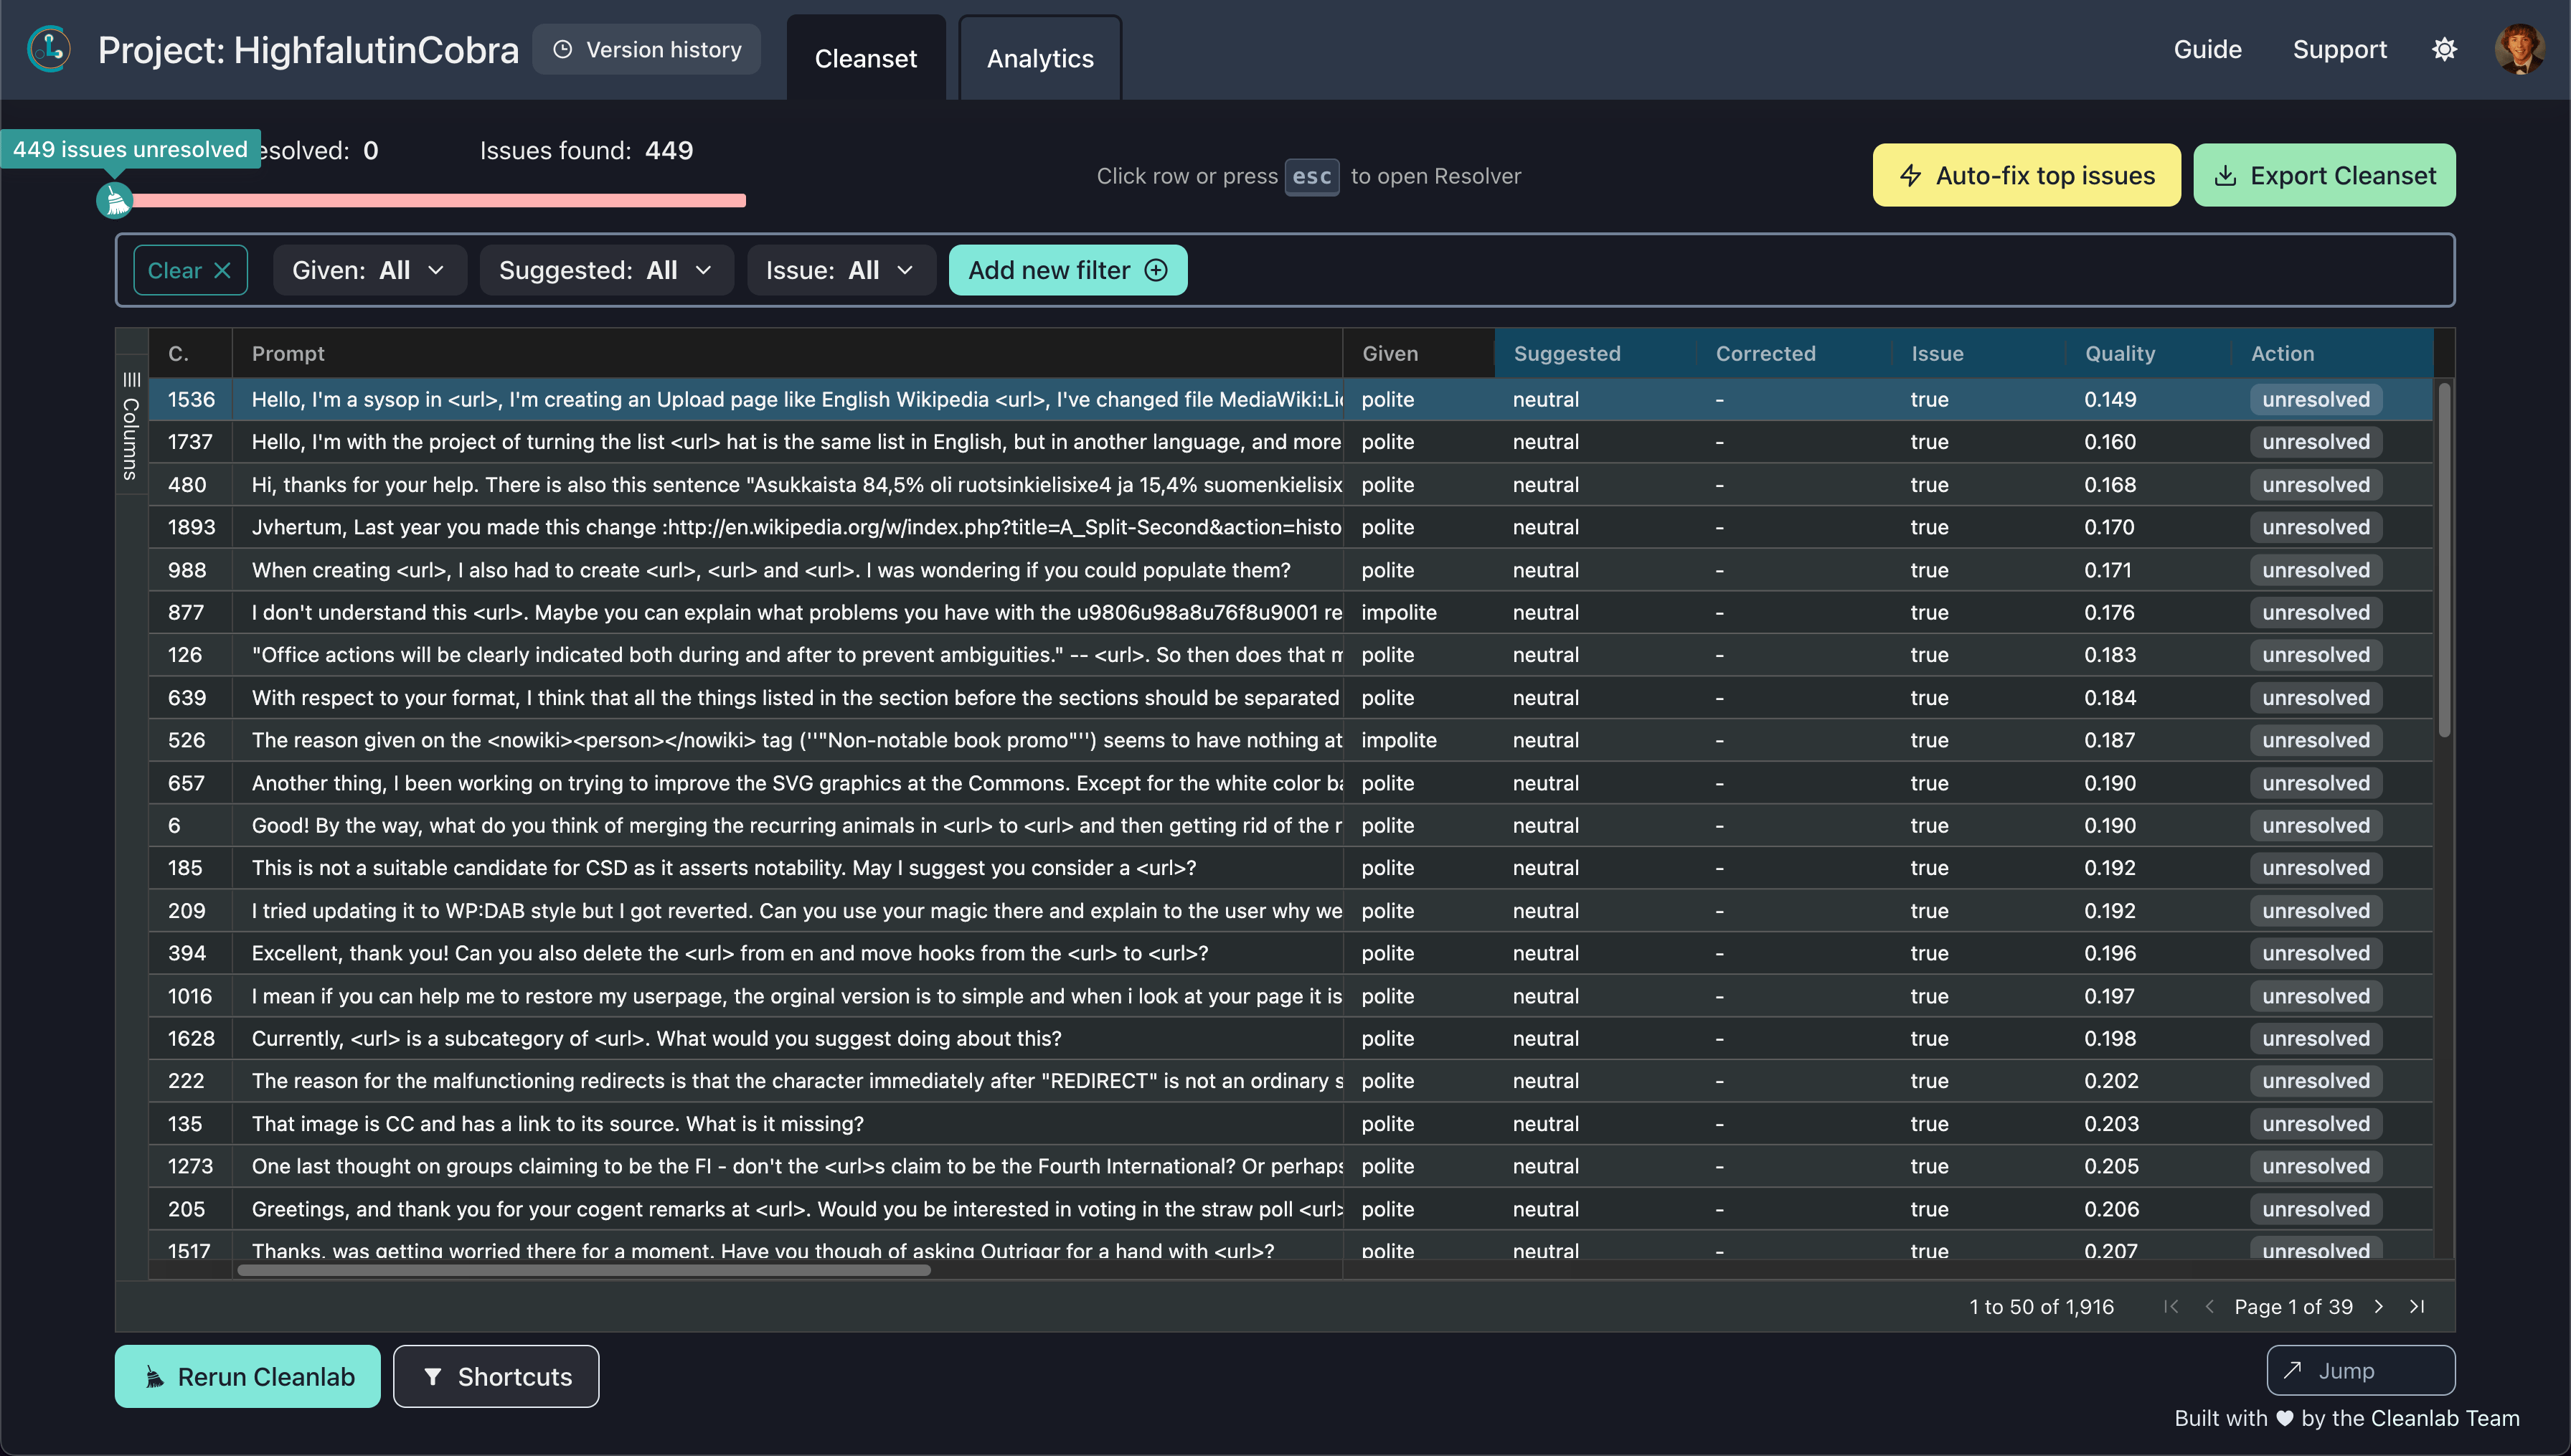

Studio automatically flags examples it thinks are likely mislabeled and provides suggested label corrections for the relevant data such that a dataset can be quickly improved. Here, we use the auto-fix feature on this dataset and replace the Studio-found label issues with the automatically-suggested label. From data upload to data export, the whole process took only 5 minutes. 

We then fine-tune the exact same Davinci LLM on the dataset corrected with Cleanlab Studio. The resulting model achieves 77**%** accuracy on the same test dataset as before, which is a **37% reduction in error** from our original version of this model.

**Note: throughout this entire process, we never changed any code related to model architecture/hyperparameters, training, or data preprocessing!**  All improvement strictly comes from increasing the quality of our training data, which leaves room for additional optimizations on the modeling side.

In [ ]:
# Load in and format data improved with Studio.
train_fixed = pd.read_csv('https://s.cleanlab.ai/stanford-politeness/fine-tuning/train_fixed.csv')
format_data(train_fixed, 'train_fixed.jsonl')

In [ ]:
# Train a more robust classifier with less erroneous data.
!openai api fine_tunes.create -t "train_fixed_prepared.jsonl" -v "test_prepared.jsonl" --compute_classification_metrics --classification_n_classes 3 -m davinci --suffix "fixed"

Found potentially duplicated files with name 'train_fixed_prepared.jsonl', purpose 'fine-tune' and size 336831 bytes
file-VzAGx7KBPBpxIDC34Tywq3of
file-yua1qZd1yc3AOwUFdlZfiLgU
file-AxfSD90pmYHJpnULJHHPZt1c
Enter file ID to reuse an already uploaded file, or an empty string to upload this file anyway: 
Upload progress: 100% 337k/337k [00:00<00:00, 398Mit/s]
Uploaded file from train_fixed_prepared.jsonl: file-sO6pCkt1etcfbCvIEwoHOayX
Found potentially duplicated files with name 'test_prepared.jsonl', purpose 'fine-tune' and size 86248 bytes
file-A8UDyjjGn77nDSTnQVpKNwZR
file-kQ9nvpgBZ4ymSwZTSHrcathS
file-Gn7Xe3h8RzjpBG2bkNt1ZpdU
file-ij3XWzohVe7DHe1MfGeOmlIK
file-JPRgknZ0XXyJpHVTslOVH5GP
file-XMpLsORHGXPHIsPpuEGhCLjT
file-47roCLnANxzRtxbfZjc0Wta3
file-MDeMFZCtCSYpzSI7UhgGXDM7
file-tGOmIEgWSMDsp1JFMoz7dRSX
Enter file ID to reuse an already uploaded file, or an empty string to upload this file anyway: 
Upload progress: 100% 86.2k/86.2k [00:00<00:00, 133Mit/s]
Uploaded file from test_prepa

In [ ]:
# Query API for results and save them to CSV that we can view.
# You will need to change the fine-tune ID from the above cell.
!openai api fine_tunes.results -i ft-MQbaduYd8UGD2EWBmfpoQpkQ > fixed-davinci.csv
fixed_df = pd.read_csv('fixed-davinci.csv')
fixed_acc = fixed_df.iloc[-1]['classification/accuracy']
print(f"Fine-tuning Accuracy: {fixed_acc:.1%}")

Fine-tuning Accuracy: 77.3%


# Evaluating other LLMs

We repeated this same experiment with two other recent LLM models OpenAI offers for fine-tuning: Ada and Curie. The resulting improvements look similar to those achieved for the Davinci model.

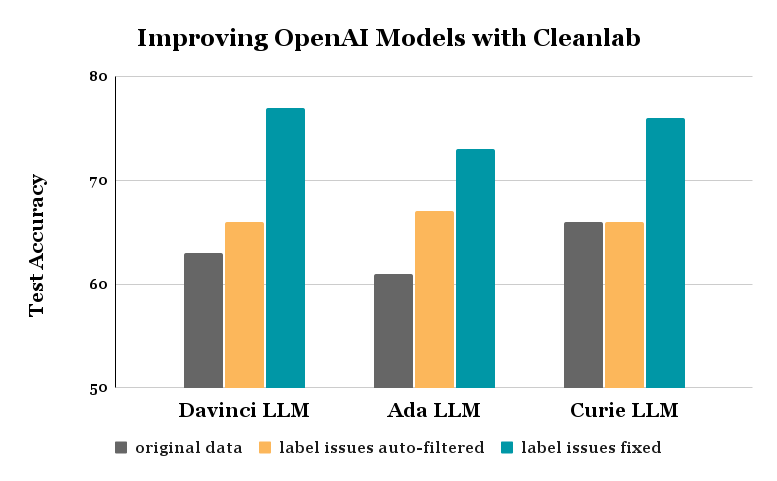

## Curie LLM

In [ ]:
# Fine-tune on original data using the curie model.
!openai api fine_tunes.create -t "train_prepared.jsonl" -v "test_prepared.jsonl" --compute_classification_metrics --classification_n_classes 3 -m curie --suffix "baseline"

In [ ]:
# Get baseline accuracy.
!openai api fine_tunes.results -i ft-5oLnoHQci5uKWrEpzdMtA6JP > baseline-curie.csv
base_df = pd.read_csv('baseline-curie.csv')
baseline_acc = base_df.iloc[-1]['classification/accuracy']
print(f"Fine-tuning Accuracy: {baseline_acc:.1%}")

Fine-tuning Accuracy: 66.3%


In [ ]:
# Fine-tune on cleanlab auto-filtered data using the curie model.
!openai api fine_tunes.create -t "train_dropped_prepared.jsonl" -v "test_prepared.jsonl" --compute_classification_metrics --classification_n_classes 3 -m curie --suffix "dropped"

In [ ]:
# Get cleanlab auto-filtered accuracy.
!openai api fine_tunes.results -i ft-pn9HDPSie8C7Q1nTkvWtvoXZ > dropped-curie.csv
dropped_df = pd.read_csv('dropped-curie.csv')
dropped_acc = dropped_df.iloc[-1]['classification/accuracy']
print(f"Fine-tuning Accuracy: {dropped_acc:.1%}")

Fine-tuning Accuracy: 65.8%


In [ ]:
# Fine-tune on Studio fixed data using the curie model.
!openai api fine_tunes.create -t "train_fixed_prepared.jsonl" -v "test_prepared.jsonl" --compute_classification_metrics --classification_n_classes 3 -m curie --suffix "fixed"

In [ ]:
# Get Studio fixed accuracy.
!openai api fine_tunes.results -i ft-PbfdxV4pVKNmpxbQYFLlcKY1 > fixed-curie.csv
fixed_df = pd.read_csv('fixed-curie.csv')
fixed_acc = fixed_df.iloc[-1]['classification/accuracy']
print(f"Fine-tuning Accuracy: {fixed_acc:.1%}")

Fine-tuning Accuracy: 75.8%


## Ada LLM

In [ ]:
# Fine-tune on original data using the Ada model.
!openai api fine_tunes.create -t "train_prepared.jsonl" -v "test_prepared.jsonl" --compute_classification_metrics --classification_n_classes 3 -m ada --suffix "baseline"

In [11]:
# Get baseline accuracy.
!openai api fine_tunes.results -i ft-B5njNShNPFMsP1UFH9DMYjFh > baseline-ada.csv
base_df = pd.read_csv('baseline-ada.csv')
baseline_acc = base_df.iloc[-1]['classification/accuracy']
print(f"Fine-tuning Accuracy: {baseline_acc:.1%}")

Fine-tuning Accuracy: 61.0%


In [ ]:
# Fine-tune on cleanlab auto-filtered data using the Ada model.
!openai api fine_tunes.create -t "train_dropped_prepared.jsonl" -v "test_prepared.jsonl" --compute_classification_metrics --classification_n_classes 3 -m ada --suffix "dropped"

In [ ]:
# Get cleanlab auto-filtered accuracy.
!openai api fine_tunes.results -i ft-CETg5biYzyfzjc6lFTdZmTpq > dropped.csv
dropped_df = pd.read_csv('dropped.csv')
dropped_acc = dropped_df.iloc[-1]['classification/accuracy']
print(f"Fine-tuning Accuracy: {dropped_acc:.1%}")

Fine-tuning Accuracy: 67.1%


In [ ]:
# Fine-tune on Studio fixed data using the Ada model.
!openai api fine_tunes.create -t "train_fixed_prepared.jsonl" -v "test_prepared.jsonl" --compute_classification_metrics --classification_n_classes 3 -m ada --suffix "fixed"

In [ ]:
# Get Studio fixed accuracy.
!openai api fine_tunes.results -i ft-lmwAPtXHCzBDkB154rVtWWL5 > fixed-ada.csv
fixed_df = pd.read_csv('fixed-ada.csv')
fixed_acc = fixed_df.iloc[-1]['classification/accuracy']
print(f"Fine-tuning Accuracy: {fixed_acc:.1%}")

Fine-tuning Accuracy: 72.7%


# Conclusion

Data-centric AI is a powerful paradigm for handling noisy data via AI/automated techniques rather than the tedious manual effort data scientists often dread. Tools like [Cleanlab](https://cleanlab.ai/studio/) help you efficiently find and fix data and label issues that can be used to improve any ML model (not just LLMs) for most types of data (not just text, but also images, audio, tabular data, etc).  [Open-source versions](https://github.com/cleanlab/cleanlab) of such tools can *utilize* any ML model to diagnose/fix issues in the data and then improve the data *for* any other ML model. [No-code platforms](https://cleanlab.ai/studio) come with good ML models built-in and interfaces to quickly correct data issues. 

These sorts of tools will still remain applicable with future advances in ML models like GPT-10, and will only become better at identifying issues when used with more accurate models!  Practice data-centric AI to systematically engineer better data via AI/automation. This frees you to capitalize on your unique domain knowledge rather than fixing general data issues like label errors.

# Next Steps

- Try improving your data with [Cleanlab Studio](https://cleanlab.ai/studio/) for free!
- Star our [github repo](https://github.com/cleanlab/cleanlab) to support open-source Data-centric AI development.
- Join our [Cleanlab Community Slack](https://cleanlab.ai/slack/) to discuss how you’re practicing data-centric AI.
- Follow us on [LinkedIn](https://www.linkedin.com/company/cleanlab/) or [Twitter](https://twitter.com/CleanlabAI) to stay up-to-date on our research on data quality algorithms.